# Station Clustering (Winter 2018)
This notebook uses K-means clustering with PCA to group stations into 3 different clusters. 

The station features are the total hourly 'Activity' and 'Flux' where: 

    Activity = num_pickups + num_dropoffs

    Flux = num_pickups - num_dropoffs

In [148]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [149]:
###
subs_df = pd.read_pickle('./data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('./data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('./data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [150]:
subs_df[subs_df['start station latitude']>41]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender


In [151]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [152]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [153]:
weekend_subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
116,1347,2018-01-06 11:12:20.973,2018-01-06 11:34:48.773,72,382,18783,Subscriber,1968,1,5,5,11,11,50,Weekend,"(72, 382)"
117,471,2018-01-06 11:43:53.488,2018-01-06 11:51:44.696,72,479,25288,Subscriber,1992,1,5,5,11,11,26,Weekend,"(72, 479)"
118,304,2018-01-06 17:15:05.323,2018-01-06 17:20:09.783,72,515,32352,Subscriber,1974,1,5,5,17,17,44,Weekend,"(72, 515)"
119,374,2018-01-07 12:42:24.651,2018-01-07 12:48:38.807,72,450,16988,Subscriber,1983,1,6,6,12,12,35,Weekend,"(72, 450)"
120,334,2018-01-07 13:48:19.772,2018-01-07 13:53:54.086,72,173,31484,Subscriber,1977,1,6,6,13,13,41,Weekend,"(72, 173)"


In [154]:
WD_puhour_groupby = weekday_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WD_puhour_df = WD_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WD_dohour_groupby = weekday_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WD_dohour_df = WD_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [155]:
WD_counts_df = pd.concat([WD_puhour_df,WD_dohour_df],axis=1).fillna(0)
WD_counts_df['total_pickups'] = WD_counts_df['NumPickups'].sum(axis=1)
WD_counts_df['total_dropoffs'] = WD_counts_df['NumDropoffs'].sum(axis=1)

In [156]:
for num in range(24):
    WD_counts_df['Activity',num] =  WD_counts_df['NumPickups',num] + WD_counts_df['NumDropoffs',num]
    WD_counts_df['Flux',num] =  WD_counts_df['NumPickups',num] - WD_counts_df['NumDropoffs',num]
WD_counts_df['total_counts'] = WD_counts_df['Activity'].sum(axis=1)

# Normalize by total activity for station -- maybe just do this right before clustering step?
for num in range(24):
    WD_counts_df['norm_Activity',num] =  WD_counts_df['Activity',num]/WD_counts_df['total_counts']
    WD_counts_df['norm_Flux',num] =  WD_counts_df['Flux',num]/WD_counts_df['total_counts']


In [157]:
WD_counts_df.sort_values('total_counts',ascending=False).head()

NumPickups                                                         \
pickup_hour         0     1     2     3     4      5       6       7       8    
519               74.0  45.0   8.0   6.0   4.0  284.0   692.0  1839.0  2760.0   
3255              38.0  31.0  10.0   6.0  65.0  194.0  2935.0  2823.0  2169.0   
402               34.0  18.0   7.0   9.0   7.0   23.0   132.0   332.0   616.0   
435               45.0  12.0   2.0   4.0  14.0   48.0   118.0   361.0   843.0   
490               68.0  23.0  19.0  20.0  94.0  332.0   773.0  1017.0  1547.0   

                       ...    norm_Activity norm_Flux norm_Activity norm_Flux  \
pickup_hour      9     ...               19        19            20        20   
519          2303.0    ...         0.071903  0.013217      0.029909  0.004688   
3255         1140.0    ...         0.039903 -0.004213      0.018872 -0.000445   
402           590.0    ...         0.063773  0.026796      0.024745  0.007636   
435           861.0    ...         0.062126  0.008248      0.040522  0.000719   
490          1065.0    ...         0.053266  0.000348      0.032369  0.002549   

            norm_Activity norm_Flux norm_Activity norm_Flux norm_Activity  \
pickup_hour            21        21            22        22            23   
519              0.015682  0.001010      0.008852  0.001253      0.004143   
3255             0.014865 -0.000343      0.011508  0.000959      0.006713   
402              0.013716  0.002899      0.009156  0.002156      0.003747   
435              0.027015  0.000681      0.009383  0.000908      0.006735   
490              0.024721  0.007416      0.022094  0.005408      0.008768   

            norm_Flux  
pickup_hour        23  
519          0.000707  
3255        -0.000959  
402          0.000990  
435          0.000151  
490          0.002665  

[5 rows x 147 columns]

In [158]:
print(len(WD_counts_df))
len(stations_info_df)

777


777

In [159]:
for el in WD_counts_df.index:
    if el not in stations_info_df.index:
        print(el)
        

In [160]:
#Imported/modified from UMICH coursera course, a simple scatter plot function
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)
    #plt.zlim(z_min, z_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    

In [161]:
import tilemapbase
tilemapbase.start_logging()

In [162]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [163]:
t = tilemapbase.tiles.Carto_Light

In [164]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

In [165]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def color_st(x):
    sns.set_color_codes()
    if x == 0:
        return 'b'
    elif x == 1:
        return 'orange'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'r'
    

# Clustering with Activity and norm_Flux

In [166]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WD_counts_df[['Activity','norm_Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 3).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(777, 48) (777, 3)


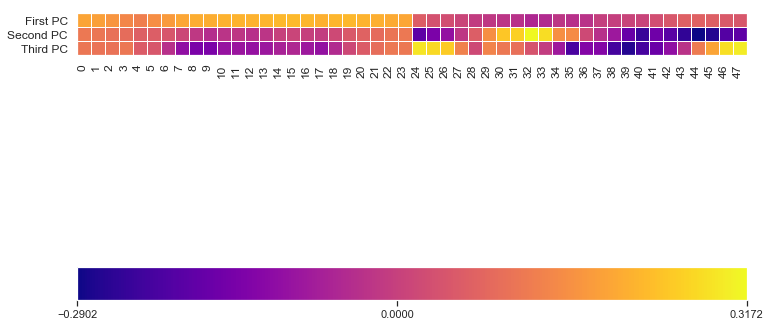

In [168]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

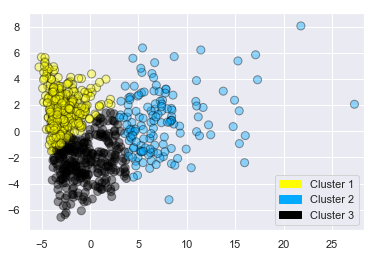

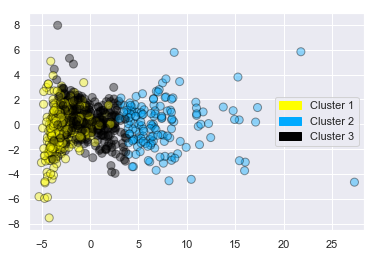

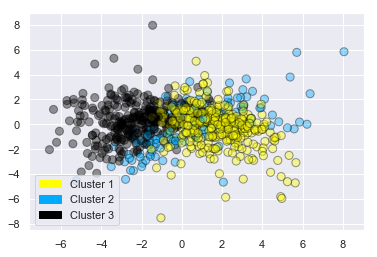

In [169]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

WD_counts_df['KNN_label'] = kmeans.labels_

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (0,2))
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (1,2))

In [170]:
test_df=WD_counts_df[['norm_Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [171]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

In [174]:
test_melt_df.head()

,hour,station,count,KNN_label
0,0,72,0.000000,2
1,1,72,0.000136,2
2,2,72,0.000816,2
3,3,72,0.000136,2
4,4,72,0.000272,2


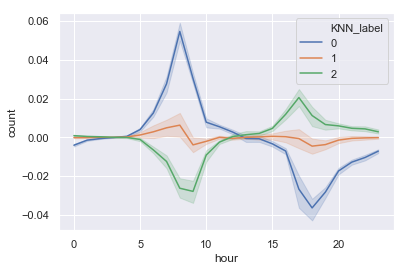

In [176]:
#Using norm_Flux 
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors=3),data=test_melt_df)

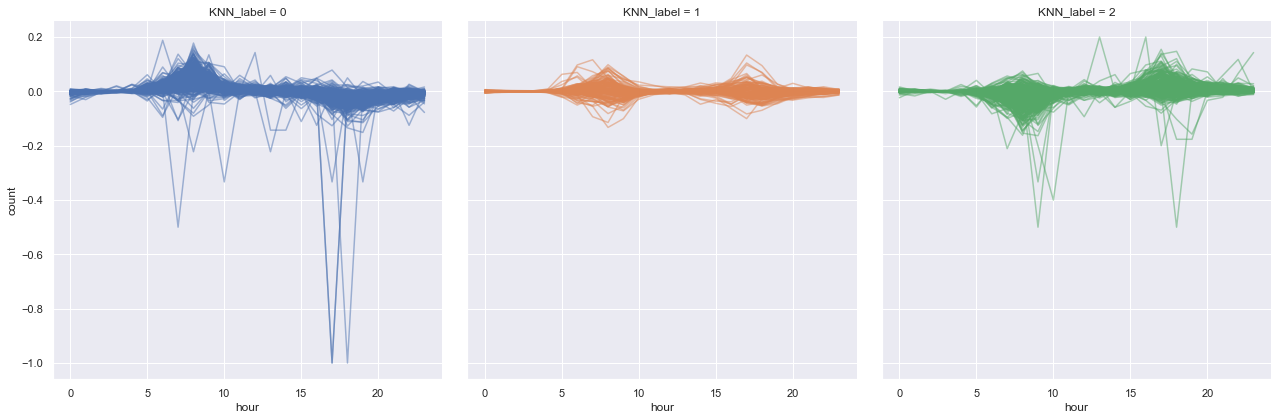

In [177]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

Plotting Activity

In [178]:
test_df=WD_counts_df[['Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [179]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

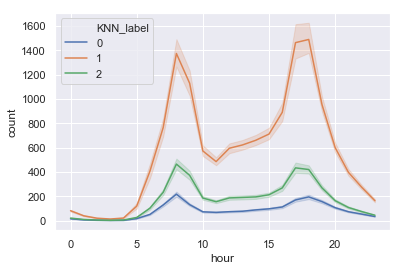

In [180]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors=3),data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


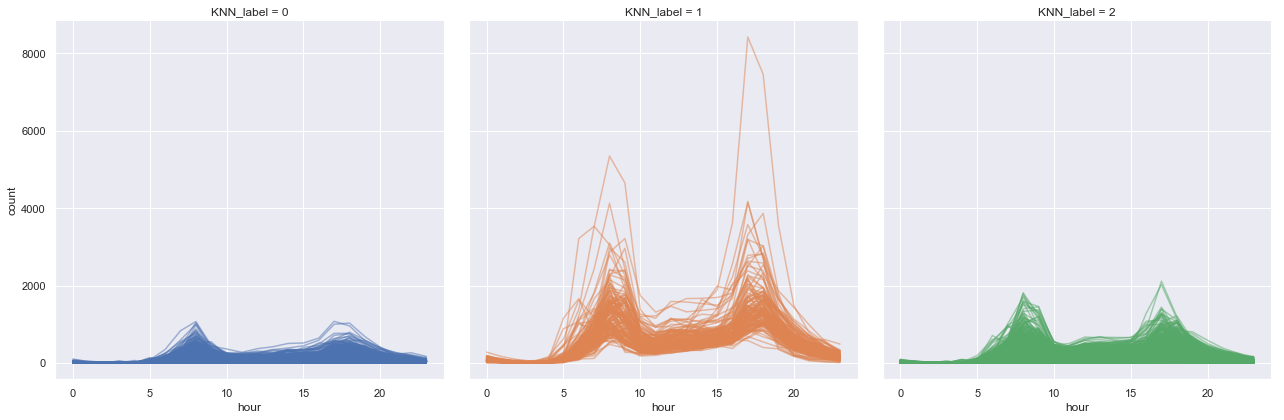

In [181]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

In [182]:
stations_info_df['KNN_label'] = WD_counts_df['KNN_label']
stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

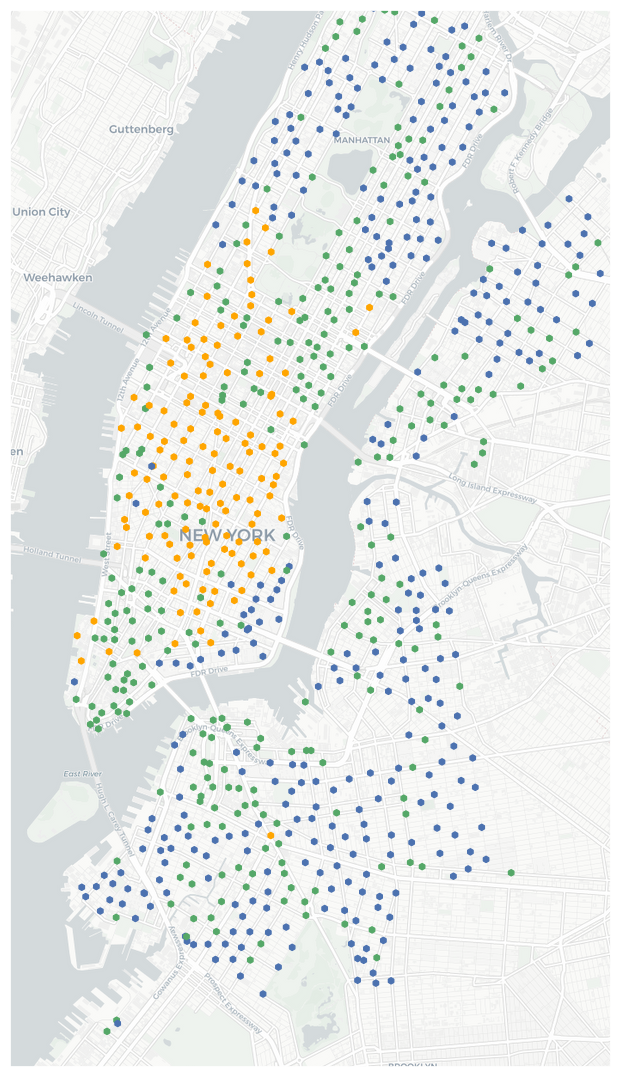

In [183]:
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)

## Now using Activity and Flux

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WD_counts_df[['Activity','Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 3).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(777, 48) (777, 3)


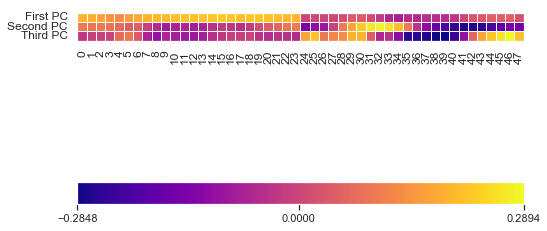

In [210]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

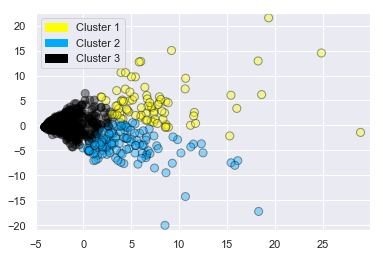

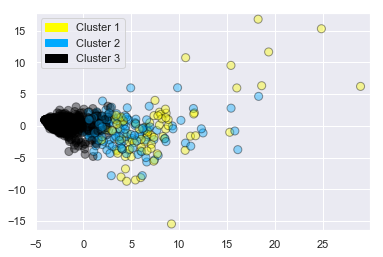

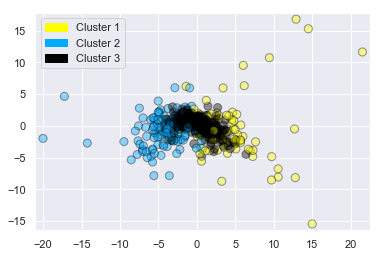

In [211]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (0,2))
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (1,2))

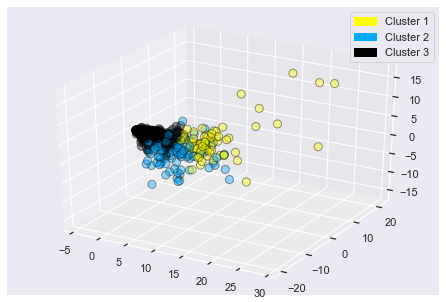

In [212]:
plot_3d_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

In [215]:
WD_counts_df['KNN_label'] = kmeans.labels_

Plotting Flux

In [216]:
test_df=WD_counts_df[['Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [217]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


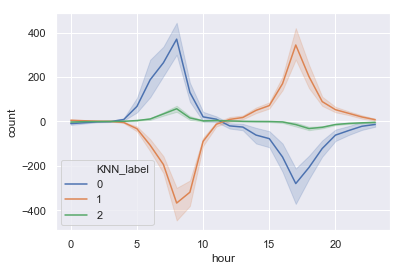

In [218]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.color_palette()

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors = 3), data=test_melt_df)

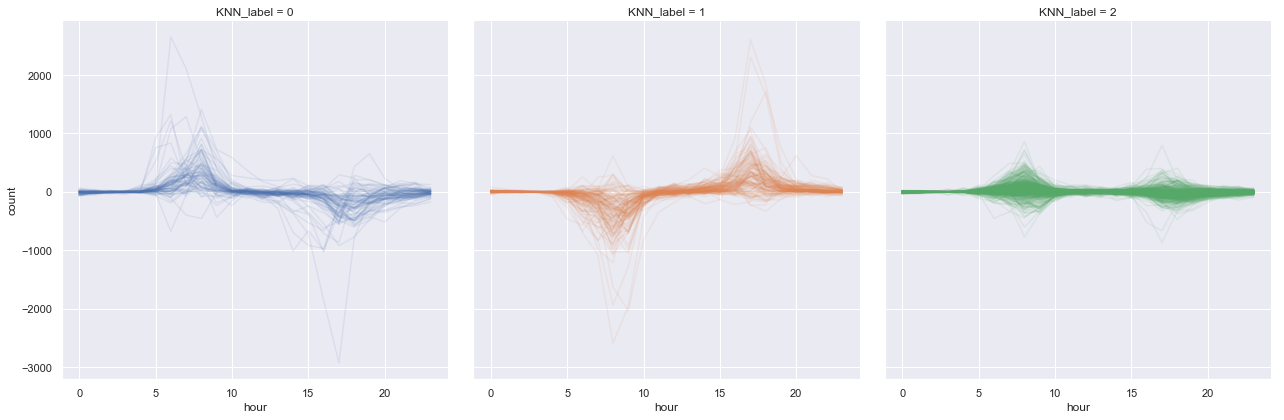

In [219]:
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.1)

Plotting Activity

In [220]:
test_df=WD_counts_df[['Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [221]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

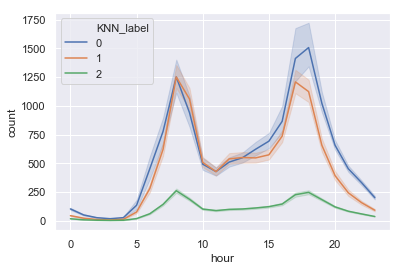

In [222]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette= sns.color_palette(n_colors=3), data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


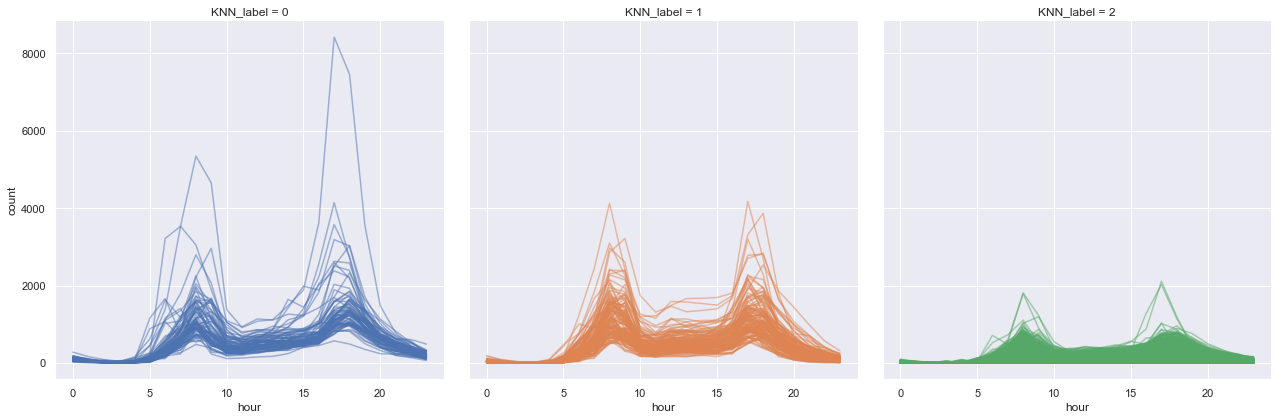

In [223]:
#Plot all stations
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

In [224]:
for num in [0,1,2]:
    print('KNN_label {}: {}'.format(num,len(WD_counts_df[WD_counts_df['KNN_label'] == num])))

KNN_label 0: 78
KNN_label 1: 127
KNN_label 2: 572


In [225]:
stations_info_df['KNN_label'] = WD_counts_df['KNN_label']
stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

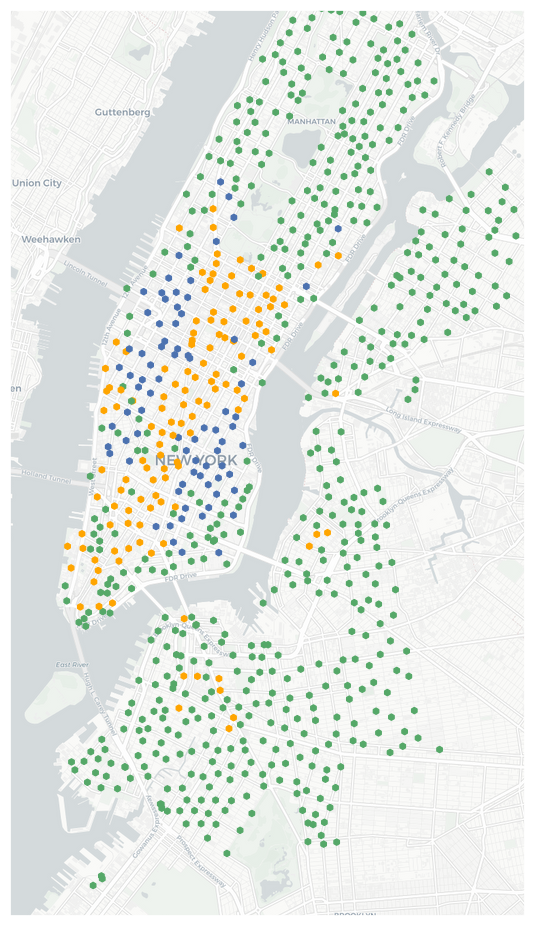

In [226]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);
   